# Introduction to Image Classification with PyTorch

We'll be using computer vision to answer the question that never gets old on the internet: is it a sloth or a pain au chocolat? This is a binary image classification task. 

![sloth_or_pain_au_chocolat.jpg](sloth_or_pain_au_chocolat.jpg)

In the age of deep learning, data scientists and machine learning engineers seldom create and train neural networks from scratch. A big chunk of what goes into performing a machine learning task, however, is collecting, preparing, and loading data to feed into a model. We'll perform a little bit of fine-tuning on the model, but this will not be the focus of the training.

In this session, we'll be adapting code from PyTorch.org's [tutorials](https://pytorch.org/tutorials) on [loading custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to load a dataset we have collected into PyTorch.

We'll then use [this tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning) to perform an image processing task using a mostly-pretrained model, which we'll fine tune.

Specifically, we'll be labeling images with one of two labels: `sloth`, or `pain_au_chocolat`.


# Package Imports

Like all great Python projects, ours too, will start with some package imports! We'll use: 
- `NumPy` for manipulating numerical arrays
- `Matplotlib.pyplot` for plotting
- `time`, which provides time-related functions
- `os`, a way of providing functionality that interacts with the operating system
- `copy`, for copying objects
- various packages from torch, including:
    - `torch`
    - `torch.nn`, which contains the basic building blocks for neural networks
    - `torch.optim`, a package containing various optimization algorithms for PyTorch
    - `lr_scheduler` from `torch.optim`, for adjusting the learning rate based on the number of epochs
    - `torch.backends.cudnn` as `cudnn`, a means for PyTorch to talk to the GPU (although GPUs may not be supported in your workspace)
- `torchvision`, which provides additional functionalities to manipulate and process images, including
    - `datasets`, which contains built in datasets
    - `models`, containing models for various tasks, including image processing
    - `transforms`, which we'll use to transform images in preparation for image processing


In [1]:
# Package imports go here
import numpy as np
import matplotlib.pyplot as plt

import time 
import os
import copy 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn 

import torchvision
from torchvision import datasets, models, transforms

## Initalizations
For fast runtime, let's begin our project by setting `cudnn.benchmark` to True. You can read more about this [here](https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936).

In [2]:
# Enable cudnn benchmark
cudnn.benchmark = True

# Reading and transforming the data

While [the PyTorch.org](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) tutorial provides extensive information on loading, transforming, rescaling, cropping, and converting images to tensors using `torch` and `torch.utils`, we'll be using the `torchvision` package, which provides some frequently used data loaders and transforms out-of-the-box.

One of the things it assumes is that data is organized in a certain way. Navigate to the data folder to see how the data is structured. Within the directory called "data/sloths_versus_pain_au_chocolat", there are two folders called `"train"` and `"val"`. Our dataset contains two labels:
- `sloth`, and
- `pain_au_chocolat`
so our folders are named and organized accordingly. Note that the images contained in the `sloth`, and `pain_au_chocolat` folders don't need to be named in any way, as long as the folders themselves are labelled correctly.

To adapt this tutorial to use different data, all you need to do is change the names of the `sloth`, and `pain_au_chocolat` folders, and upload different images into them.    

When running code in notebooks, sometimes a file called `.ipynb_checkpoints` can show up in our training and validation folders. We'll remove these with the lines below.

In [ ]:
import os

# Define the path to the dataset
data_path = 'data/sloths_versus_pain_au_chocolat'

# List the contents of the dataset directory
for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

In [3]:
# Banish pesky .ipynb files
!rm -R data/sloths_versus_pain_au_chocolat/train/.ipynb_checkpoints

!rm -R data/sloths_versus_pain_au_chocolat/val/.ipynb_checkpoints

rm: cannot remove 'data/sloths_versus_pain_au_chocolat/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'data/sloths_versus_pain_au_chocolat/val/.ipynb_checkpoints': No such file or directory


We'll begin loading and transforming our data by defining the specific transforms we'd like to use from `torchvision`.

The specific transforms we'll use on our training set are:
- `RandomResizedCrop()`, used to crop a random portion of an image and resize it to a given size, passed as the first argument to the function
- `RandomHorizontalFlip()`, used to horizontally flip an image randomly with a given probability (default is 0.5)
- `ToTensor()`, used to convert an image or `numpy.ndarray` to a tensor
- `Normalize()`, used to normalize a tensor image with given means and standard deviations, passed as lists as the first and second arguments, respectively (taking tensors as input). If the images are similar to ImageNet images, we can use the mean and standard deviation of the ImageNet dataset. These are:
    - `mean` = [0.485, 0.456, 0.406] 
    - `std` = [0.229, 0.224, 0.225].

The specific transforms we'll use on our validation set are:
- `Resize()` used to resize an input to a given size, passed as the first argument
- `CenterCrop()` to crop a given image at the center, based on dimensions provided in the first argument
- `ToTensor()`
- `Normalize()`

In [4]:
# Create data transforms
data_transforms = {
    'train' : transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
        ]
    ),
    'val' : transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
        ]
    )
}

Next, we'll:
- create a data directory path containing our dataset
- pass our directory to `datasets.ImageFolder()` to create a data loader called `image_datasets`, where the images are arranged in the same way our folders are currently structured
- use `image_datasets` to obtain our training and validation `dataset_sizes` and `class_names`
- pass `image_datasets` to `torch.utils.data.DataLoader()`, which enables us to sample from our dataset, using
    - `batch_size` = 4, which uses 4 images per batch
    - `shuffle` = True, which will shuffle the data at every epoch


In [5]:
# Provide data directory
data_dir = 'data/sloths_versus_pain_au_chocolat'

# Create image folders for our training and validation data 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]
                                         )
                 for x in ['train', 'val']}

# Obtain dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Obtain class_names from image_datasets
class_names = image_datasets['train'].classes
print(class_names)

# Use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size = 4,          
                                              shuffle=True)
               for x in ['train', 'val']}

['pain_au_chocolat', 'sloths']


In [6]:
# Change selected device to CUDA, a parallel processing platform, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualizing sloths and pastries with a custom function! 

## Defining the function

In [7]:
def imshow(inp, title=None):
    """
    This function will make use of Matplotlib.pyplot's imshow() function for tensors. 
    It will show the same number of images as the batch we defined.
    """
    # A transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0)) 

    # Using default values for mean and std but can customize
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    
    # To visualize the correct colors     
    inp = std * inp + mean
    
    # To view a clipped version of an image             
    inp = np.clip(inp, 0, 1)
    
    # Visualize inp
    plt.imshow(inp)
    
    if title is not None: # Plot title goes here
        plt.title(title)
    plt.pause(0.001)  # Enables the function to pause while the plots are updated


## Calling our `imshow()` function

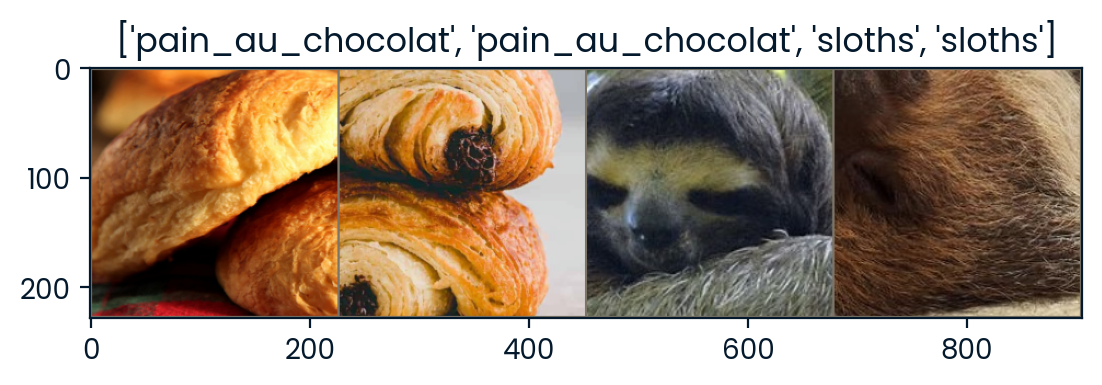

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

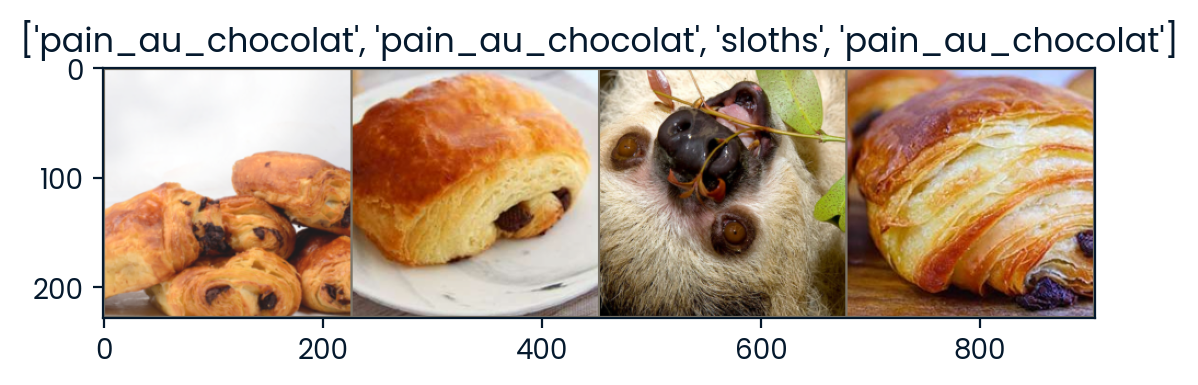

In [9]:
# Get a batch of validation data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

# Running the model with 25 epochs

We'll now apply a pre-trained model on our data. We won't go over the details of the model, but the code used to create the function `train_model()` is provided below.

## Samples, batches and epochs
- A sample is a single image or a single row of data.
- A batch is a group of images. Batch size will determine the number of samples to work through before a hyperparameter is updated.
- An epoch is the number of times the model or learning algorithm will encounter all samples in the dataset. In one epoch, the complete dataset will have had an opportunity to update the internal model parameters.

## Defining functions for training the model and visualizing model results

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function that will train model based on data provided.
    '''
    
    since = time.time()

    # Make a deep copy of the model provided     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # Print an empty line for nice formatting

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    '''
    Function that will visualize results of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Loading a pre-trained model

We'll use a model called ResNet18, developed by authors [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1512.03385).


In [12]:
# Load the resnet model
model_ft = models.resnet18(pretrained=True)

# Obtaining the number of input features for our final layer
num_ftrs = model_ft.fc.in_features

# Since this is a binary classification task, we'll set the size of each output sample to 2. For multi-class classification, this can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_ft = model_ft.to(device)

# We'll use CrossEntropyLoss(), which is a common loss function for classification problems
criterion = nn.CrossEntropyLoss()

# In this step, we'll optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# We'll decay learning rate (lr) by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/repl/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
# Call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.4038 Acc: 0.8204
val Loss: 0.0032 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.1727 Acc: 0.9281
val Loss: 0.0111 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.2515 Acc: 0.9222
val Loss: 0.0265 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3793 Acc: 0.8683
val Loss: 0.0056 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.6344 Acc: 0.8204
val Loss: 0.0024 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2636 Acc: 0.9222
val Loss: 0.0419 Acc: 1.0000

Epoch 6/24
----------


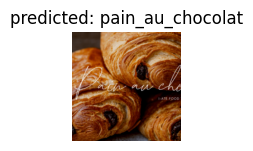

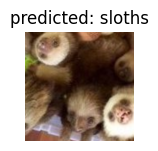

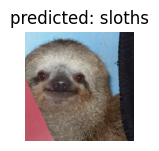

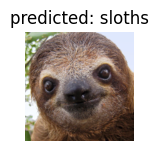

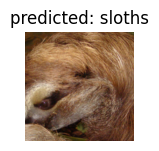

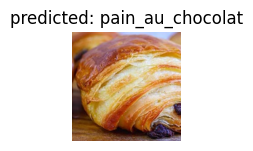

In [35]:
visualize_model(model_ft)

In [13]:
# Disable gradients for model_conv.parameters()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_conv = model_conv.to(device)

# Set criterion again
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
# Train model_conv
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [15]:
# Visualize model
visualize_model(model_conv)
plt.show()

# Where to next?

## Tutorials
- [Tutorial] [A beginner's guide to object detection](https://www.datacamp.com/tutorial/object-detection-guide)

## DataCamp courses
- [Course] [Introduction to Deep Learning with PyTorch](https://campus.datacamp.com/courses/introduction-to-deep-learning-with-pytorch/introduction-to-pytorch-a-deep-learning-library?ex=1)
- [Course: coming soon] Intermediate Deep Learning with PyTorch
- [Course: coming soon] Deep Learning for Images with PyTorch


## DataCamp tracks
- [Skill track] [Image Processing with Python ](https://app.datacamp.com/learn/skill-tracks/image-processing)